In [1]:
%cd ../..

/home/work/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
T=100
dt=1
Boundary=6
signal_noise_ratio = 0.2

In [6]:
def generate_trajectory():
    x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, 1, Boundary)
    STATEs = np.zeros((T+1, 4))
    Disps = np.zeros((T, 2))
    init_state = np.array([x0[0], y0[0], init_v_rand_dir[0, 0], init_v_rand_dir[0, 1]])

    STATEs, Disps, _ = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)
    return STATEs, Disps

In [7]:
import os.path

if os.path.isfile('examples/dynamical_ball/trajectory.data'):
    trajectory_dict = torch.load('examples/dynamical_ball/trajectory.data')
    STATEs = trajectory_dict['STATEs']
    Disps = trajectory_dict['Disps']
else:
    STATEs, Disps = generate_trajectory()
    STATEs = torch.tensor(STATEs, dtype=torch.float32)
    Disps = torch.tensor(Disps, dtype=torch.float32)
    trajectory_dict = {
        'STATEs': STATEs,
        'Disps': Disps,
    }
    torch.save(trajectory_dict, 'examples/dynamical_ball/trajectory.data')

In [8]:
def generate_trajectory_trace():
    trajectory = STATEs
    displacements = Disps

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = point[:2]
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [9]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [10]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [11]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [12]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [13]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [14]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [15]:
def generative_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(bouncing_ball_step, initializer=init_bouncing_ball),
                           lambda: range(T))

In [16]:
def recognition_model(num_particles):
    init_bouncing_ball = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    bouncing_ball_step = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return init_bouncing_ball, bouncing_ball_step

In [17]:
def attach_proposals(model, num_particles):
    init_proposal, step_proposal = recognition_model(num_particles)

    init_selector = lambda m: m.name == 'InitBallDynamics'
    init_attach = lambda m: importance.Propose(m, init_proposal)
    model = model.apply(init_attach, init_selector)

    step_selector = lambda m: m.name == 'StepBallDynamics'
    step_attach = lambda m: importance.Propose(m, step_proposal)
    return model.apply(step_attach, step_selector)

In [18]:
def training_model(num_particles, inference_strategy):
    model = generative_model(num_particles)
    model = attach_proposals(model, num_particles)
    return inference_strategy(model)

In [19]:
trajectory, displacements, data = generate_trajectory_trace()

In [20]:
def train_model(num_particles, inference_strategy, inclusive_kl=False, plot_bounds=True, log_estimator=False):
    sampler = training_model(num_particles, inference_strategy)
    
    tau, params, evidence_bounds = importance.variational_importance(
        sampler, 100, data, use_cuda=True, lr=1e-1,
        inclusive_kl=inclusive_kl, patience=100,
        log_estimator=log_estimator,
    )
    
    if plot_bounds:
        utils.plot_evidence_bounds(evidence_bounds, not inclusive_kl)
    
    return sampler, tau, evidence_bounds

In [21]:
def evaluate_inference(sampler, tau):
    inferred_trajectory = accumulate_trajectory(tau)

    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([tau['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)

    graph_original_trajectory(trajectory, T, 0)
    graph_inferred_trajectory(positions, T, 0)
    graph_displacement_trajectories(velocity_steps, displacements, T, 0)
    
    for t in range(T+1):
        logging.info('MSE at time %d: %s' % (t, ((data['position_%d' % t] - positions[t])**2).sum(dim=0)))

In [22]:
sample_sizes = [2, 10, 100]
SAMPLING_STRATEGIES = ['Monte Carlo importance sampling', 'Importance Weighted sampling', 'Sequential Monte Carlo']
sampling_strategies = [(lambda m: m, False), (lambda m: m, True), (lambda m: importance.smc(m), False)]
kl_directions = [True]

In [23]:
def experiment():
    results = {}
    for i, (inference_strategy, estimator) in enumerate(sampling_strategies):
        for inclusive_kl in kl_directions:
            for num_particles in sample_sizes:
                logging.info('Experimenting with sampling strategy: ' + SAMPLING_STRATEGIES[i])
                logging.info('Experimenting with sample size of %d', num_particles)
                logging.info('Experimenting with %s training', 'Wake-Sleep' if inclusive_kl else 'Variational')
                sampler, tau, evidence_bounds = train_model((num_particles,), inference_strategy, inclusive_kl, plot_bounds=True, log_estimator=estimator)
                evaluate_inference(sampler, tau)
                results[(SAMPLING_STRATEGIES[i], num_particles, inclusive_kl)] = (tau, evidence_bounds)
    return results

03/03/2019 16:41:36 Experimenting with sampling strategy: Monte Carlo importance sampling
03/03/2019 16:41:36 Experimenting with sample size of 2
03/03/2019 16:41:36 Experimenting with Wake-Sleep training
03/03/2019 16:41:36 EUBO=6.62611877e+02 at epoch 1
03/03/2019 16:41:36 EUBO=1.02227368e+03 at epoch 2
03/03/2019 16:41:37 EUBO=4.63944458e+02 at epoch 3
03/03/2019 16:41:37 EUBO=7.78373718e+02 at epoch 4
03/03/2019 16:41:37 EUBO=4.40600403e+02 at epoch 5
03/03/2019 16:41:37 EUBO=5.59148926e+02 at epoch 6
03/03/2019 16:41:38 EUBO=7.13673950e+02 at epoch 7
03/03/2019 16:41:38 EUBO=4.96902466e+02 at epoch 8
03/03/2019 16:41:38 EUBO=4.68807129e+02 at epoch 9
03/03/2019 16:41:38 EUBO=4.24260681e+02 at epoch 10
03/03/2019 16:41:39 EUBO=4.48601929e+02 at epoch 11
03/03/2019 16:41:39 EUBO=7.45680054e+02 at epoch 12
03/03/2019 16:41:39 EUBO=4.44605835e+02 at epoch 13
03/03/2019 16:41:39 EUBO=4.19034332e+02 at epoch 14
03/03/2019 16:41:39 EUBO=4.73567963e+02 at epoch 15
03/03/2019 16:41:40 EUBO

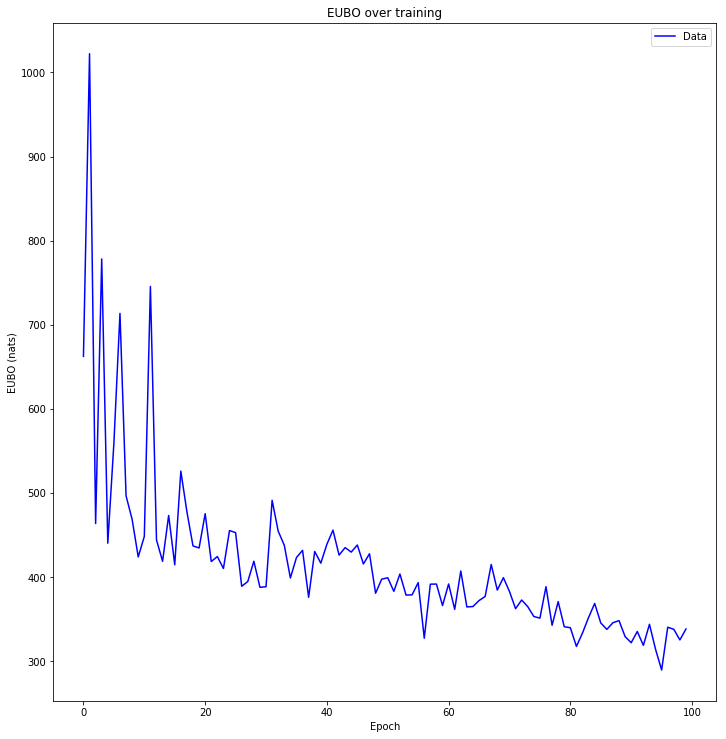

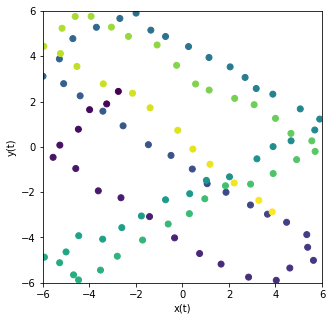

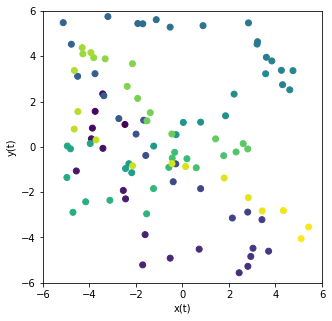

03/03/2019 16:42:13 MSE at time 0: tensor(2.2128)
03/03/2019 16:42:13 MSE at time 1: tensor(0.2249)
03/03/2019 16:42:13 MSE at time 2: tensor(0.0622)
03/03/2019 16:42:13 MSE at time 3: tensor(0.3663)
03/03/2019 16:42:13 MSE at time 4: tensor(3.4538)
03/03/2019 16:42:13 MSE at time 5: tensor(3.3803)
03/03/2019 16:42:13 MSE at time 6: tensor(0.0123)
03/03/2019 16:42:13 MSE at time 7: tensor(1.1562)
03/03/2019 16:42:13 MSE at time 8: tensor(0.0416)
03/03/2019 16:42:13 MSE at time 9: tensor(0.6706)
03/03/2019 16:42:13 MSE at time 10: tensor(3.3073)
03/03/2019 16:42:13 MSE at time 11: tensor(1.6415)
03/03/2019 16:42:13 MSE at time 12: tensor(1.3225)
03/03/2019 16:42:13 MSE at time 13: tensor(0.2021)
03/03/2019 16:42:13 MSE at time 14: tensor(1.8742)
03/03/2019 16:42:13 MSE at time 15: tensor(3.0761)
03/03/2019 16:42:13 MSE at time 16: tensor(3.8787)
03/03/2019 16:42:13 MSE at time 17: tensor(5.5297)
03/03/2019 16:42:13 MSE at time 18: tensor(4.1563)
03/03/2019 16:42:13 MSE at time 19: tenso

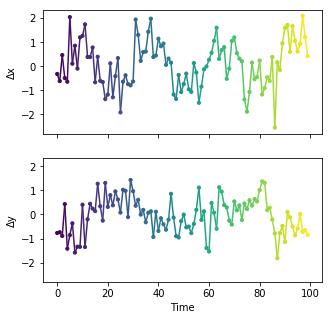

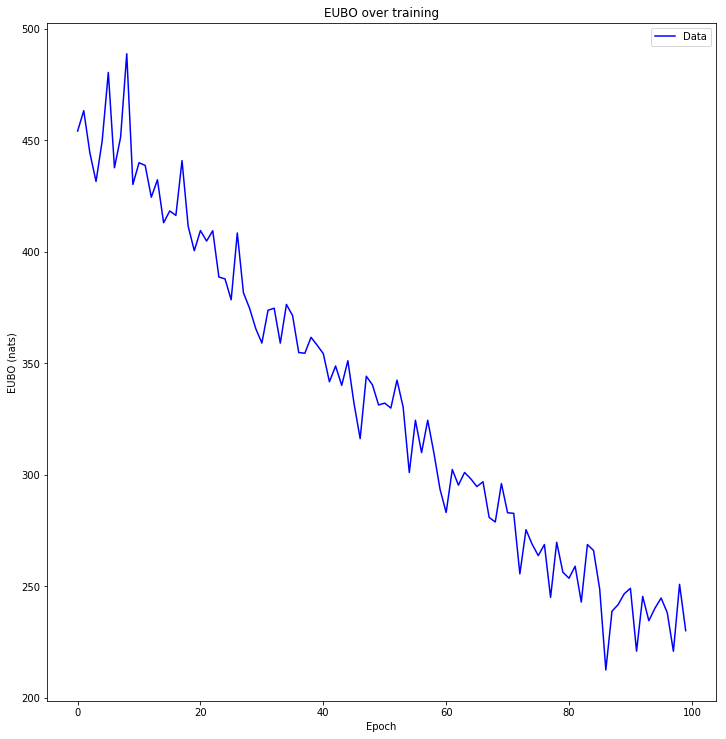

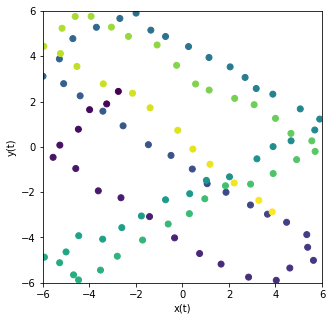

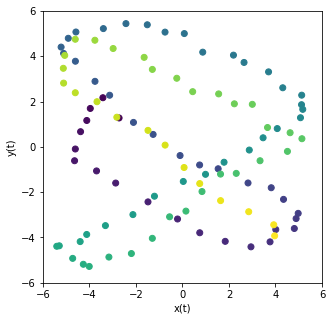

03/03/2019 16:42:56 MSE at time 0: tensor(1.3773)
03/03/2019 16:42:56 MSE at time 1: tensor(0.1011)
03/03/2019 16:42:56 MSE at time 2: tensor(0.0039)
03/03/2019 16:42:56 MSE at time 3: tensor(0.2798)
03/03/2019 16:42:56 MSE at time 4: tensor(1.1471)
03/03/2019 16:42:56 MSE at time 5: tensor(1.0486)
03/03/2019 16:42:56 MSE at time 6: tensor(0.1205)
03/03/2019 16:42:56 MSE at time 7: tensor(0.7773)
03/03/2019 16:42:56 MSE at time 8: tensor(0.4715)
03/03/2019 16:42:56 MSE at time 9: tensor(0.4259)
03/03/2019 16:42:56 MSE at time 10: tensor(0.7096)
03/03/2019 16:42:56 MSE at time 11: tensor(0.8413)
03/03/2019 16:42:56 MSE at time 12: tensor(1.0401)
03/03/2019 16:42:56 MSE at time 13: tensor(1.7995)
03/03/2019 16:42:56 MSE at time 14: tensor(2.9531)
03/03/2019 16:42:56 MSE at time 15: tensor(3.2536)
03/03/2019 16:42:56 MSE at time 16: tensor(2.6529)
03/03/2019 16:42:56 MSE at time 17: tensor(1.8530)
03/03/2019 16:42:56 MSE at time 18: tensor(1.0173)
03/03/2019 16:42:56 MSE at time 19: tenso

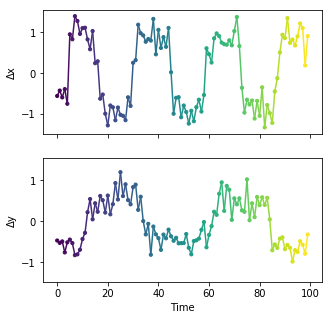

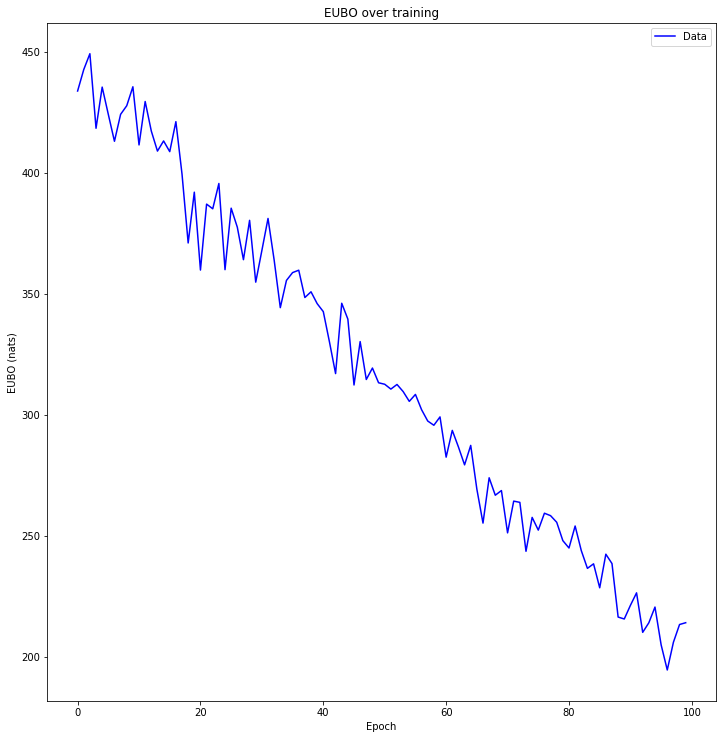

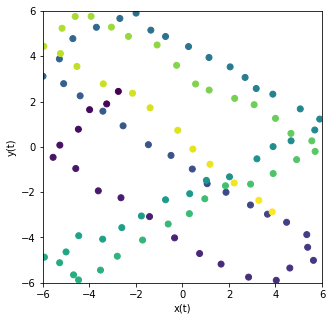

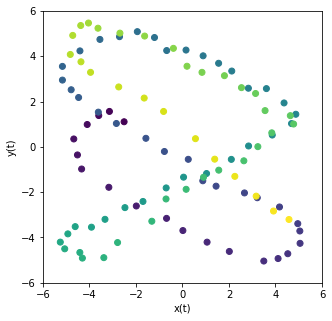

03/03/2019 16:43:47 MSE at time 0: tensor(1.8588)
03/03/2019 16:43:47 MSE at time 1: tensor(0.1242)
03/03/2019 16:43:47 MSE at time 2: tensor(0.2220)
03/03/2019 16:43:47 MSE at time 3: tensor(0.1882)
03/03/2019 16:43:47 MSE at time 4: tensor(0.4339)
03/03/2019 16:43:47 MSE at time 5: tensor(1.1081)
03/03/2019 16:43:47 MSE at time 6: tensor(0.0636)
03/03/2019 16:43:47 MSE at time 7: tensor(0.2297)
03/03/2019 16:43:47 MSE at time 8: tensor(0.5684)
03/03/2019 16:43:47 MSE at time 9: tensor(0.5416)
03/03/2019 16:43:47 MSE at time 10: tensor(0.2320)
03/03/2019 16:43:47 MSE at time 11: tensor(0.3558)
03/03/2019 16:43:47 MSE at time 12: tensor(0.4384)
03/03/2019 16:43:47 MSE at time 13: tensor(0.9328)
03/03/2019 16:43:47 MSE at time 14: tensor(0.9291)
03/03/2019 16:43:47 MSE at time 15: tensor(0.4060)
03/03/2019 16:43:47 MSE at time 16: tensor(0.8951)
03/03/2019 16:43:47 MSE at time 17: tensor(0.6290)
03/03/2019 16:43:47 MSE at time 18: tensor(0.3836)
03/03/2019 16:43:47 MSE at time 19: tenso

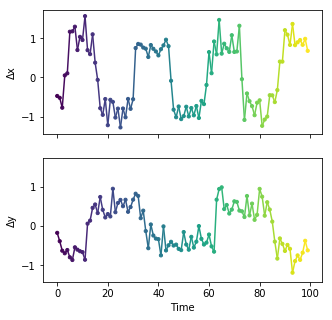

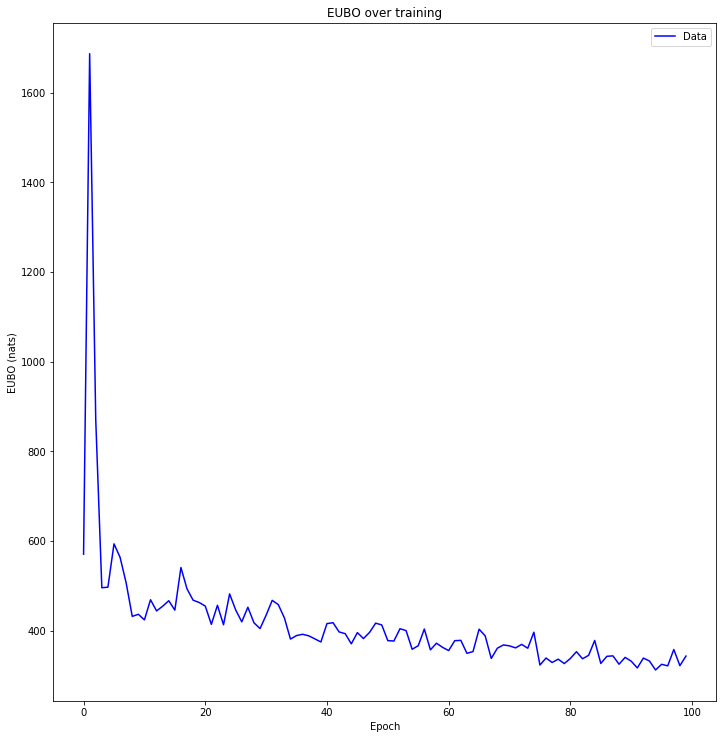

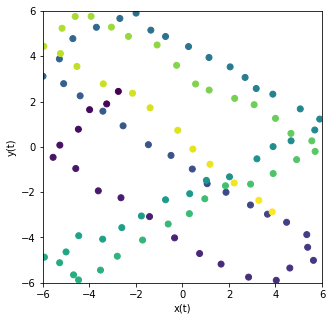

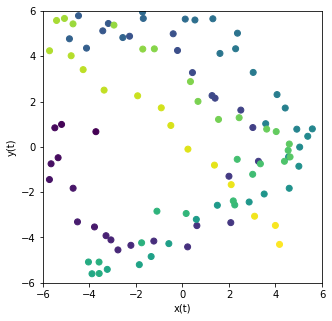

03/03/2019 16:44:28 MSE at time 0: tensor(4.0991)
03/03/2019 16:44:28 MSE at time 1: tensor(4.5867)
03/03/2019 16:44:28 MSE at time 2: tensor(2.8768)
03/03/2019 16:44:28 MSE at time 3: tensor(2.3412)
03/03/2019 16:44:28 MSE at time 4: tensor(0.8204)
03/03/2019 16:44:28 MSE at time 5: tensor(0.9881)
03/03/2019 16:44:28 MSE at time 6: tensor(0.7709)
03/03/2019 16:44:28 MSE at time 7: tensor(2.5717)
03/03/2019 16:44:28 MSE at time 8: tensor(4.6325)
03/03/2019 16:44:28 MSE at time 9: tensor(4.2148)
03/03/2019 16:44:28 MSE at time 10: tensor(7.4992)
03/03/2019 16:44:28 MSE at time 11: tensor(12.3564)
03/03/2019 16:44:28 MSE at time 12: tensor(15.7326)
03/03/2019 16:44:28 MSE at time 13: tensor(19.1446)
03/03/2019 16:44:28 MSE at time 14: tensor(16.7218)
03/03/2019 16:44:28 MSE at time 15: tensor(19.4795)
03/03/2019 16:44:28 MSE at time 16: tensor(15.4070)
03/03/2019 16:44:28 MSE at time 17: tensor(21.2889)
03/03/2019 16:44:28 MSE at time 18: tensor(14.8051)
03/03/2019 16:44:28 MSE at time 1

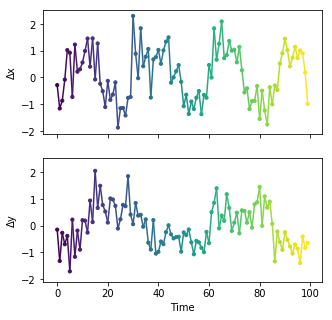

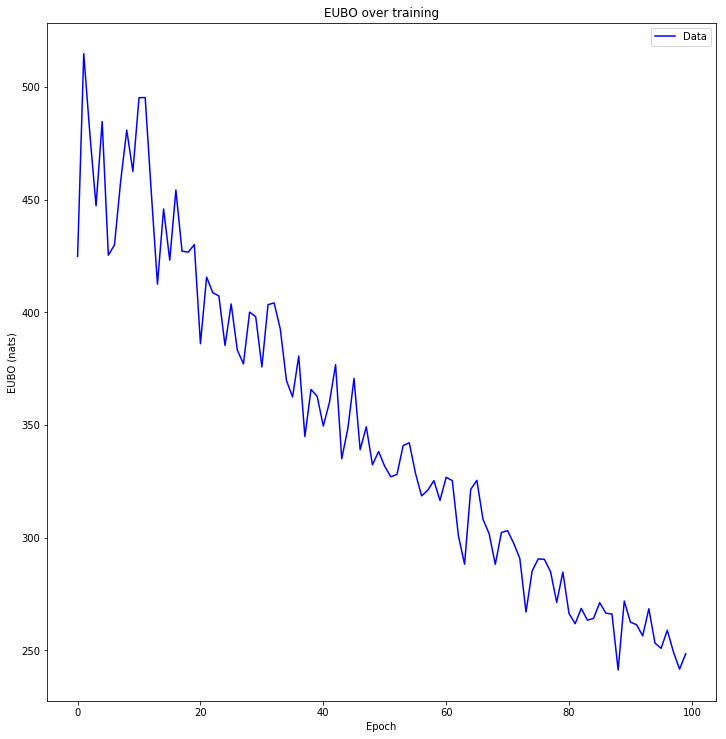

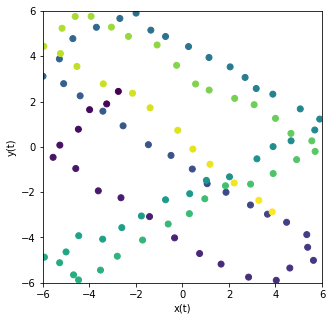

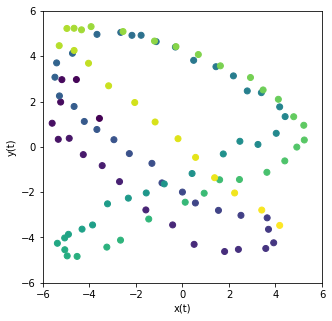

03/03/2019 16:45:04 MSE at time 0: tensor(2.0859)
03/03/2019 16:45:04 MSE at time 1: tensor(2.8544)
03/03/2019 16:45:04 MSE at time 2: tensor(3.1799)
03/03/2019 16:45:04 MSE at time 3: tensor(2.0187)
03/03/2019 16:45:04 MSE at time 4: tensor(1.0439)
03/03/2019 16:45:04 MSE at time 5: tensor(0.6813)
03/03/2019 16:45:04 MSE at time 6: tensor(1.8552)
03/03/2019 16:45:04 MSE at time 7: tensor(2.9747)
03/03/2019 16:45:04 MSE at time 8: tensor(2.6639)
03/03/2019 16:45:04 MSE at time 9: tensor(4.0483)
03/03/2019 16:45:04 MSE at time 10: tensor(3.0460)
03/03/2019 16:45:04 MSE at time 11: tensor(2.9400)
03/03/2019 16:45:04 MSE at time 12: tensor(2.1033)
03/03/2019 16:45:04 MSE at time 13: tensor(2.3425)
03/03/2019 16:45:04 MSE at time 14: tensor(4.5139)
03/03/2019 16:45:04 MSE at time 15: tensor(1.8155)
03/03/2019 16:45:04 MSE at time 16: tensor(3.5252)
03/03/2019 16:45:04 MSE at time 17: tensor(3.4661)
03/03/2019 16:45:04 MSE at time 18: tensor(3.4528)
03/03/2019 16:45:04 MSE at time 19: tenso

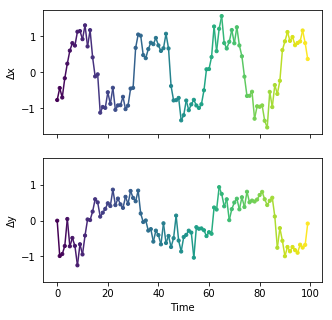

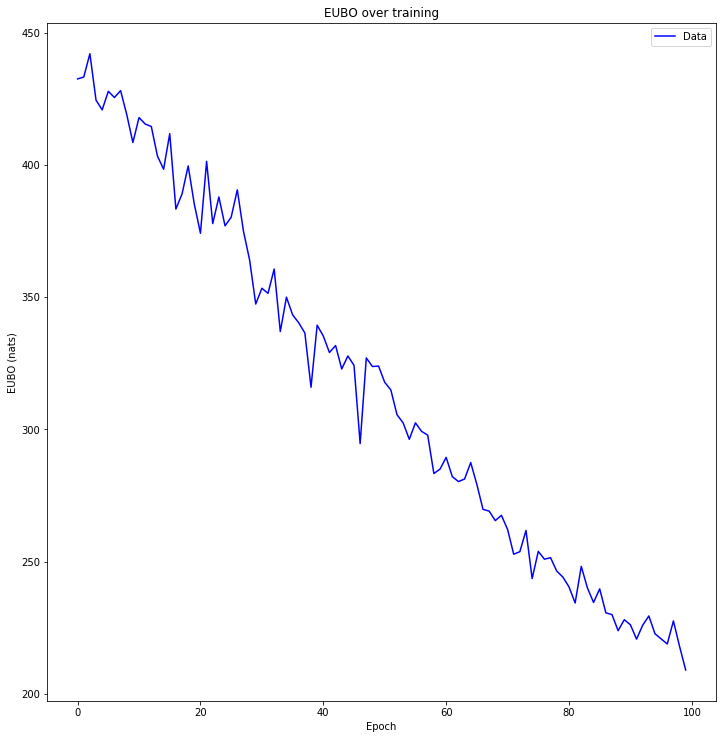

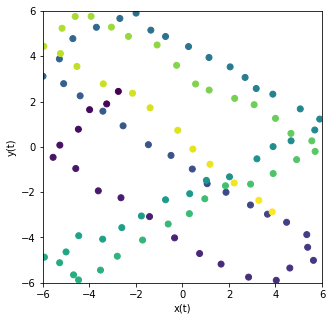

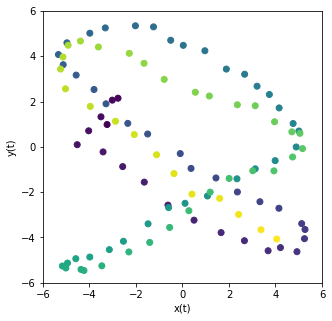

03/03/2019 16:45:41 MSE at time 0: tensor(2.3764)
03/03/2019 16:45:41 MSE at time 1: tensor(0.3003)
03/03/2019 16:45:41 MSE at time 2: tensor(1.1329)
03/03/2019 16:45:41 MSE at time 3: tensor(1.2448)
03/03/2019 16:45:41 MSE at time 4: tensor(1.9380)
03/03/2019 16:45:41 MSE at time 5: tensor(1.3856)
03/03/2019 16:45:41 MSE at time 6: tensor(1.9140)
03/03/2019 16:45:41 MSE at time 7: tensor(2.2439)
03/03/2019 16:45:41 MSE at time 8: tensor(1.4791)
03/03/2019 16:45:41 MSE at time 9: tensor(0.8848)
03/03/2019 16:45:41 MSE at time 10: tensor(1.3113)
03/03/2019 16:45:41 MSE at time 11: tensor(1.7080)
03/03/2019 16:45:41 MSE at time 12: tensor(2.0750)
03/03/2019 16:45:41 MSE at time 13: tensor(2.0633)
03/03/2019 16:45:41 MSE at time 14: tensor(2.1168)
03/03/2019 16:45:41 MSE at time 15: tensor(0.6146)
03/03/2019 16:45:41 MSE at time 16: tensor(1.0632)
03/03/2019 16:45:41 MSE at time 17: tensor(0.6306)
03/03/2019 16:45:41 MSE at time 18: tensor(0.2829)
03/03/2019 16:45:41 MSE at time 19: tenso

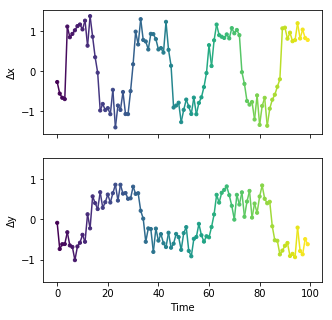

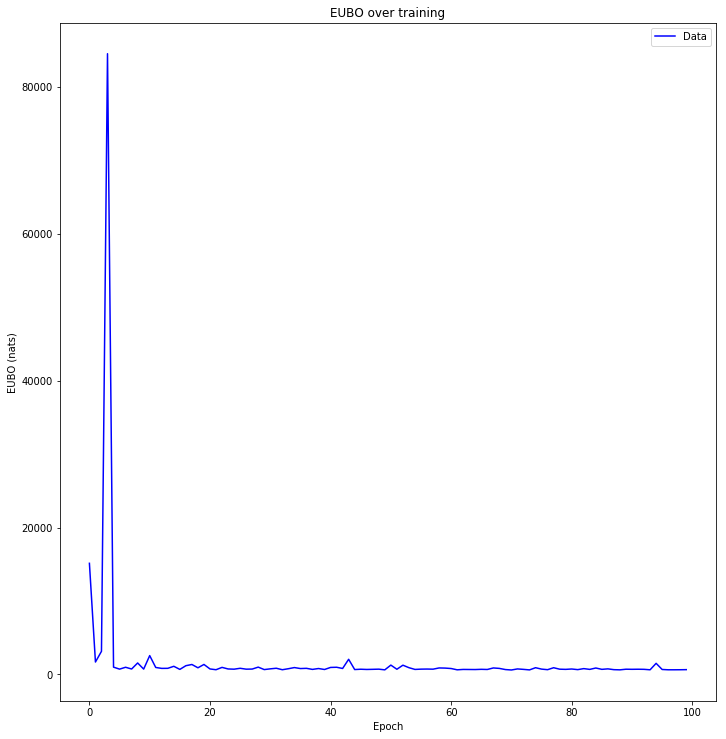

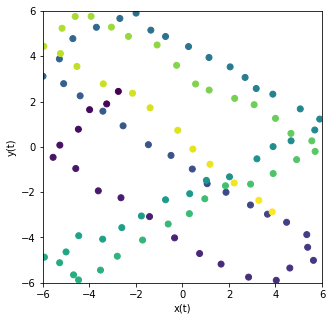

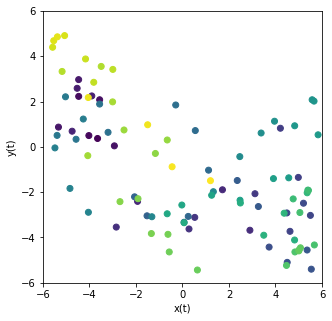

03/03/2019 16:46:27 MSE at time 0: tensor(20.7891)
03/03/2019 16:46:27 MSE at time 1: tensor(2.4842)
03/03/2019 16:46:27 MSE at time 2: tensor(1.3074)
03/03/2019 16:46:27 MSE at time 3: tensor(2.1023)
03/03/2019 16:46:27 MSE at time 4: tensor(6.9459)
03/03/2019 16:46:27 MSE at time 5: tensor(7.2023)
03/03/2019 16:46:27 MSE at time 6: tensor(3.8959)
03/03/2019 16:46:27 MSE at time 7: tensor(24.8205)
03/03/2019 16:46:27 MSE at time 8: tensor(26.8949)
03/03/2019 16:46:27 MSE at time 9: tensor(34.5546)
03/03/2019 16:46:27 MSE at time 10: tensor(41.5913)
03/03/2019 16:46:27 MSE at time 11: tensor(12.4166)
03/03/2019 16:46:27 MSE at time 12: tensor(10.7694)
03/03/2019 16:46:27 MSE at time 13: tensor(4.2885)
03/03/2019 16:46:27 MSE at time 14: tensor(52.8808)
03/03/2019 16:46:27 MSE at time 15: tensor(21.7743)
03/03/2019 16:46:27 MSE at time 16: tensor(29.6550)
03/03/2019 16:46:27 MSE at time 17: tensor(10.7249)
03/03/2019 16:46:27 MSE at time 18: tensor(23.3415)
03/03/2019 16:46:27 MSE at ti

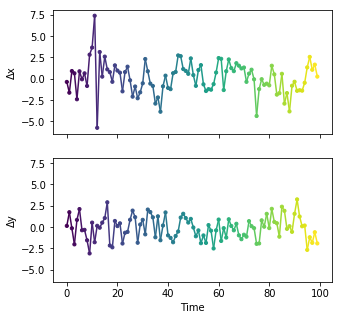

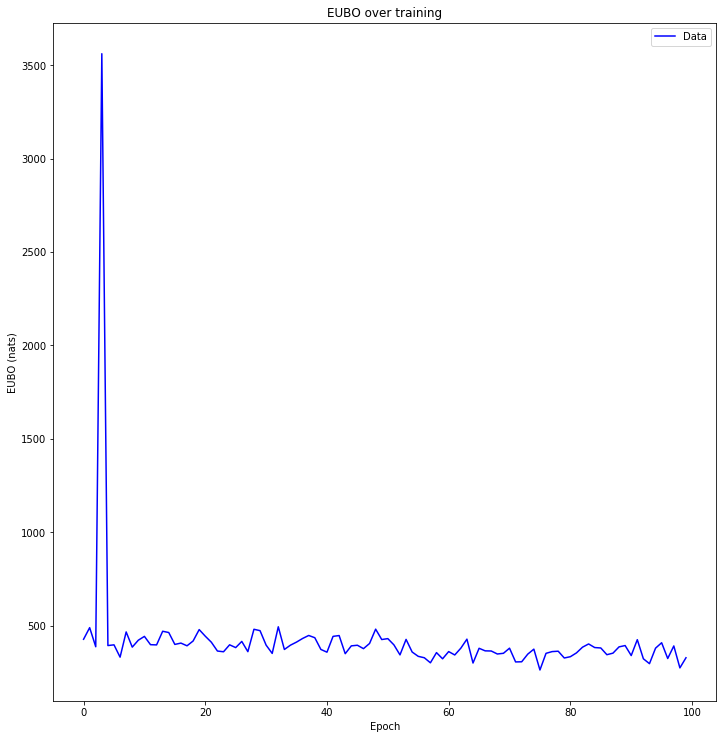

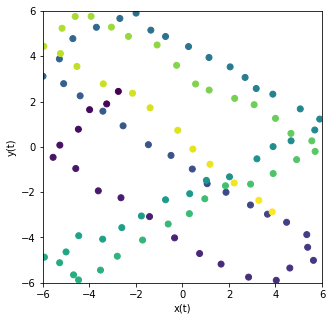

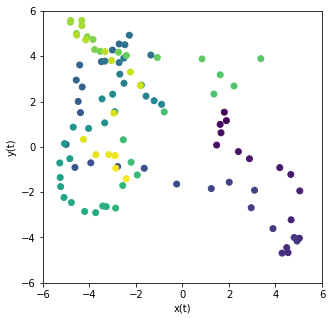

03/03/2019 16:47:16 MSE at time 0: tensor(23.2542)
03/03/2019 16:47:16 MSE at time 1: tensor(25.7267)
03/03/2019 16:47:16 MSE at time 2: tensor(31.9418)
03/03/2019 16:47:16 MSE at time 3: tensor(37.6684)
03/03/2019 16:47:16 MSE at time 4: tensor(45.4761)
03/03/2019 16:47:16 MSE at time 5: tensor(63.5767)
03/03/2019 16:47:16 MSE at time 6: tensor(56.0086)
03/03/2019 16:47:16 MSE at time 7: tensor(61.9740)
03/03/2019 16:47:16 MSE at time 8: tensor(54.4155)
03/03/2019 16:47:16 MSE at time 9: tensor(43.0508)
03/03/2019 16:47:16 MSE at time 10: tensor(25.7658)
03/03/2019 16:47:16 MSE at time 11: tensor(18.8717)
03/03/2019 16:47:16 MSE at time 12: tensor(8.5057)
03/03/2019 16:47:16 MSE at time 13: tensor(4.0499)
03/03/2019 16:47:16 MSE at time 14: tensor(1.5048)
03/03/2019 16:47:16 MSE at time 15: tensor(1.5136)
03/03/2019 16:47:16 MSE at time 16: tensor(1.7020)
03/03/2019 16:47:16 MSE at time 17: tensor(2.9030)
03/03/2019 16:47:16 MSE at time 18: tensor(7.1180)
03/03/2019 16:47:16 MSE at ti

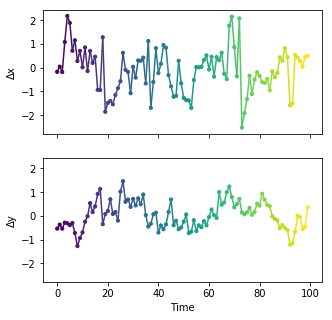

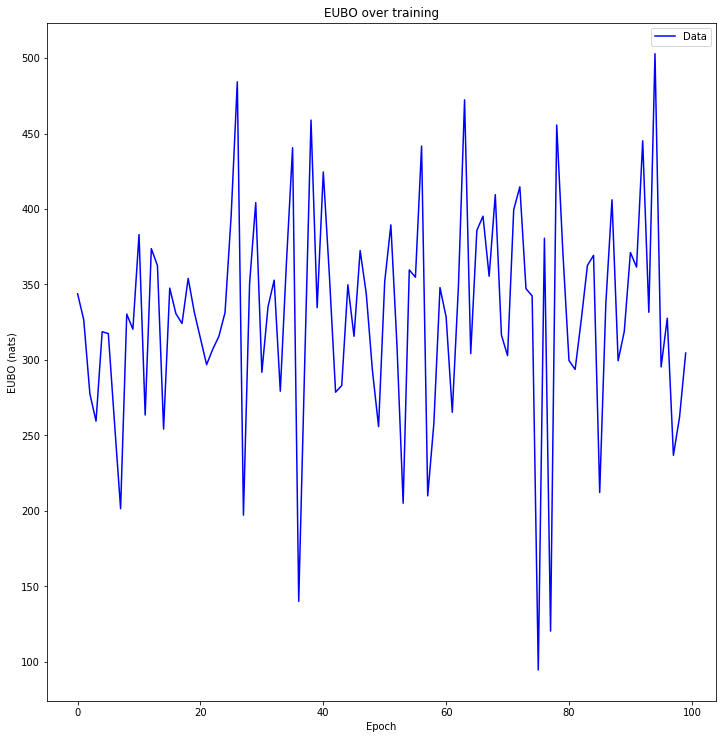

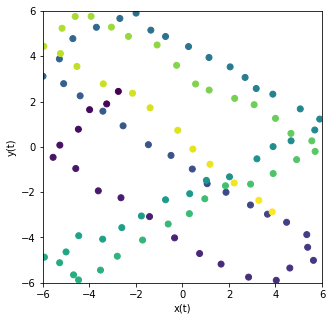

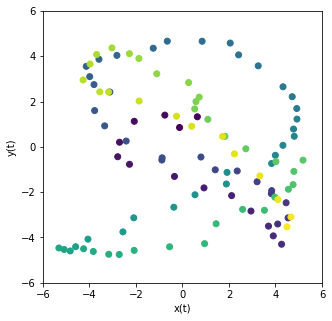

03/03/2019 16:48:13 MSE at time 0: tensor(9.4694)
03/03/2019 16:48:13 MSE at time 1: tensor(15.5365)
03/03/2019 16:48:13 MSE at time 2: tensor(10.5318)
03/03/2019 16:48:13 MSE at time 3: tensor(5.9013)
03/03/2019 16:48:13 MSE at time 4: tensor(6.6029)
03/03/2019 16:48:13 MSE at time 5: tensor(7.7246)
03/03/2019 16:48:13 MSE at time 6: tensor(5.3756)
03/03/2019 16:48:13 MSE at time 7: tensor(11.1332)
03/03/2019 16:48:13 MSE at time 8: tensor(12.9390)
03/03/2019 16:48:13 MSE at time 9: tensor(13.3251)
03/03/2019 16:48:13 MSE at time 10: tensor(12.2002)
03/03/2019 16:48:13 MSE at time 11: tensor(10.2520)
03/03/2019 16:48:13 MSE at time 12: tensor(6.5938)
03/03/2019 16:48:13 MSE at time 13: tensor(4.1222)
03/03/2019 16:48:13 MSE at time 14: tensor(6.1828)
03/03/2019 16:48:13 MSE at time 15: tensor(4.9081)
03/03/2019 16:48:13 MSE at time 16: tensor(7.8444)
03/03/2019 16:48:13 MSE at time 17: tensor(8.0534)
03/03/2019 16:48:13 MSE at time 18: tensor(6.0499)
03/03/2019 16:48:13 MSE at time 19

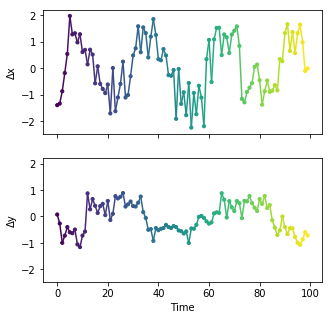

In [24]:
results_dict = experiment()

In [25]:
torch.save(results_dict, 'examples/dynamical_ball/experiment_results.data')